In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(237)  # for reproducibility

In [2]:
class CatDogDataset(Dataset):
    def __init__(self, root_dir, file_list, transform=None):
        self.root_dir = root_dir
        self.files = file_list
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        path = os.path.join(self.root_dir, filename)

        img = Image.open(path).convert("RGB")

        if "cat" in filename.lower():
            label = 0
        else:
            label = 1

        if self.transform:
            img = self.transform(img)

        return img, label

In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


    
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

root = "data/catdog/train"
files = os.listdir(root)
files = [f for f in files if f.lower().endswith(("jpg","jpeg","png"))]

# 파일명 → 라벨
labels = []
for f in files:
    if "cat" in f.lower():
        labels.append(0)
    else:
        labels.append(1)

labels = np.array(labels)
files  = np.array(files)

# ---------------------------------------
# ⭐ Stratified Train / Val / Test Split
# ---------------------------------------

# 1) 먼저 train vs temp (val+test)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    files, labels, test_size=0.3, stratify=labels, random_state=42
)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

trainset = CatDogDataset(root, train_files, transform)
testset   = CatDogDataset(root, temp_files, transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader   = DataLoader(testset, batch_size=32, shuffle=False)

In [4]:
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")

train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Image shape: torch.Size([3, 224, 224])
Label: 1
Train dataset size: 17500 (Shape: torch.Size([]))
Test dataset size: 7500 (Shape: torch.Size([]))


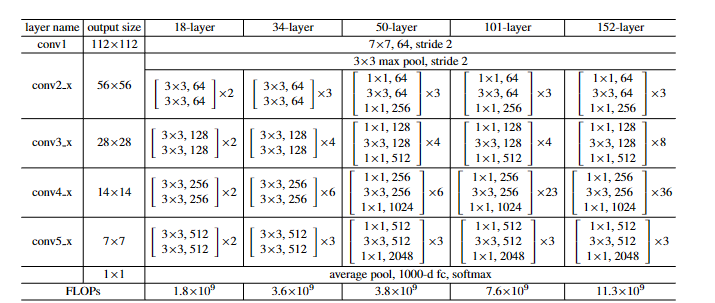

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1, skip=True):
        super().__init__()
        self.skip = skip
        
        self.conv1 = nn.Conv2d(in_channel, out_channel, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channel)
        
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channel)
        
        # downsample = Conv1x1 + BN (stride 반영)
        if skip and (stride != 1 or in_channel != out_channel):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.downsample = None

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(identity)
            out += identity

        out = self.relu(out)
        return out

class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channel, mid_channel, stride=1, skip=True):
        super().__init__()
        self.skip = skip

        # conv1 (1x1)
        self.conv1 = nn.Conv2d(in_channel, mid_channel, 1, stride=stride, bias=False)
        self.bn1   = nn.BatchNorm2d(mid_channel)

        # conv2 (3x3)
        self.conv2 = nn.Conv2d(mid_channel, mid_channel, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(mid_channel)

        # conv3 (1x1)
        self.conv3 = nn.Conv2d(mid_channel, mid_channel * self.expansion, 1, bias=False)
        self.bn3   = nn.BatchNorm2d(mid_channel * self.expansion)

        # downsample ● conv1x1 with BN
        out_channel = mid_channel * self.expansion
        if skip and (stride != 1 or in_channel != out_channel):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channel)
            )
        else:
            self.downsample = None

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(identity)
            out += identity

        out = self.relu(out)
        return out

In [6]:
# Resnet 모델 자체를 생성하는 클래스입니다.
class RESnet(nn.Module):
    def __init__(self,num_list = [3,4,6,3] ,skip_connection = True, num_classes=2, bottleneck = False):
        super(RESnet, self).__init__()

        layers = [
            nn.Conv2d(3,64,kernel_size=7,padding=3),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2) 
        ]
        channel_list = [64,128,256,512]
        pre_channel = 64
        stride = 1
        for i, (num_blocks, channel) in enumerate(zip(num_list,channel_list)):              
            for j in range(num_blocks):
                if (j == 0) and (i != 0):
                    stride = 2
                    pre_channel = channel_list[i-1] if not bottleneck else 2*channel_list[i] 
                elif (j != 0):
                    stride = 1
                    pre_channel = channel_list[i] if not bottleneck else 4*channel_list[i]
                if bottleneck:
                    layers.append(BottleneckBlock(pre_channel,channel, stride, skip_connection))
                else :
                    layers.append(BasicBlock(pre_channel,channel, stride, skip_connection))
                    
        
        
        c = 2048 if bottleneck else 512
            
        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
            nn.Linear(c, num_classes)
        )



    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [7]:
EPOCH = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
import time

current_time = time.time()

resnet50 = RESnet(bottleneck=True).to(device)

for param in resnet50.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

resnet50_train_losses = []
resnet50_val_accuracy = []

# === Early Stopping 설정 ===
patience = 5              # 몇 epoch 동안 개선 없으면 멈출지
best_val_acc = 0.0        # 지금까지의 최고 검증 정확도
patience_counter = 0       # 개선 안 된 epoch 수
best_model_path = "best_resnet50.pth"  # 최고 성능 모델 저장 경로

for epoch in range(EPOCH):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # 이 부분은 running_loss를 epoch 전체 loss로 쓰고 싶으면
    # 에폭 한 번 동안의 총 loss를 다시 계산해서 나누는 게 더 정확하지만,
    # 일단 기존 구조를 크게 안 건드리고 둘게.
    train_loss = running_loss / max(1, len(trainloader))
    train_acc = 100 * correct / total
    resnet50_train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    # ====== Validation ======
    resnet50.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    resnet50_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

    # ====== Early Stopping 체크 ======
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(resnet50.state_dict(), best_model_path)
        print(f">>> Best model updated. val_acc = {best_val_acc:.2f}% 저장됨")
    else:
        patience_counter += 1
        print(f">>> EarlyStopping counter: {patience_counter} / {patience}")
        if patience_counter >= patience:
            print(">>> 검증 정확도 개선이 없어 학습을 조기 종료합니다.")
            break

print("Finished Training")
print("총 학습 시간:", time.time() - current_time, "초")

# 나중에 best model 불러올 때
# best_model = RESnet().to(device)
# best_model.load_state_dict(torch.load(best_model_path))
# best_model.eval()

[1,   100] loss: 0.749
[1,   200] loss: 0.701
[1,   300] loss: 0.691
[1,   400] loss: 0.667
[1,   500] loss: 0.672
Epoch 1: Train Accuracy: 58.49%
Epoch 1: Validation Accuracy: 54.20%
>>> Best model updated. val_acc = 54.20% 저장됨
[2,   100] loss: 0.703
[2,   200] loss: 0.648
[2,   300] loss: 0.646
[2,   400] loss: 0.639
[2,   500] loss: 0.630
Epoch 2: Train Accuracy: 61.18%
Epoch 2: Validation Accuracy: 63.60%
>>> Best model updated. val_acc = 63.60% 저장됨
[3,   100] loss: 0.629
[3,   200] loss: 0.618
[3,   300] loss: 0.625
[3,   400] loss: 0.621
[3,   500] loss: 0.618
Epoch 3: Train Accuracy: 65.69%
Epoch 3: Validation Accuracy: 64.79%
>>> Best model updated. val_acc = 64.79% 저장됨
[4,   100] loss: 0.624
[4,   200] loss: 0.628
[4,   300] loss: 0.604
[4,   400] loss: 0.594
[4,   500] loss: 0.593
Epoch 4: Train Accuracy: 67.33%
Epoch 4: Validation Accuracy: 62.49%
>>> EarlyStopping counter: 1 / 5
[5,   100] loss: 0.571
[5,   200] loss: 0.588
[5,   300] loss: 0.577
[5,   400] loss: 0.594
[5, 

In [9]:
import time

current_time = time.time()

plain50 = RESnet(bottleneck=True,skip_connection=False).to(device)

for param in plain50.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(plain50.parameters(), lr=0.001)

plain50_train_losses = []
plain50_val_accuracy = []

# === Early Stopping 설정 ===
patience = 5              # 몇 epoch 동안 개선 없으면 멈출지
best_val_acc = 0.0        # 지금까지의 최고 검증 정확도
patience_counter = 0       # 개선 안 된 epoch 수
best_model_path = "best_plain50.pth"  # 최고 성능 모델 저장 경로

for epoch in range(EPOCH):
    plain50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = plain50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

    # 이 부분은 running_loss를 epoch 전체 loss로 쓰고 싶으면
    # 에폭 한 번 동안의 총 loss를 다시 계산해서 나누는 게 더 정확하지만,
    # 일단 기존 구조를 크게 안 건드리고 둘게.
    train_loss = running_loss / max(1, len(trainloader))
    train_acc = 100 * correct / total
    plain50_train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    # ====== Validation ======
    plain50.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = plain50(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    plain50_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

    # ====== Early Stopping 체크 ======
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(plain50.state_dict(), best_model_path)
        print(f">>> Best model updated. val_acc = {best_val_acc:.2f}% 저장됨")
    else:
        patience_counter += 1
        print(f">>> EarlyStopping counter: {patience_counter} / {patience}")
        if patience_counter >= patience:
            print(">>> 검증 정확도 개선이 없어 학습을 조기 종료합니다.")
            break

print("Finished Training")
print("총 학습 시간:", time.time() - current_time, "초")

# 나중에 best model 불러올 때
# best_model = RESnet().to(device)
# best_model.load_state_dict(torch.load(best_model_path))
# best_model.eval()

[1,   100] loss: 0.721
[1,   200] loss: 0.698
[1,   300] loss: 0.697
[1,   400] loss: 0.700
[1,   500] loss: 0.695
Epoch 1: Train Accuracy: 50.55%
Epoch 1: Validation Accuracy: 50.31%
>>> Best model updated. val_acc = 50.31% 저장됨
[2,   100] loss: 0.696
[2,   200] loss: 0.696
[2,   300] loss: 0.703
[2,   400] loss: 0.698
[2,   500] loss: 0.694
Epoch 2: Train Accuracy: 50.79%
Epoch 2: Validation Accuracy: 50.61%
>>> Best model updated. val_acc = 50.61% 저장됨
[3,   100] loss: 0.693
[3,   200] loss: 0.692
[3,   300] loss: 0.697
[3,   400] loss: 0.695
[3,   500] loss: 0.695
Epoch 3: Train Accuracy: 52.00%
Epoch 3: Validation Accuracy: 51.92%
>>> Best model updated. val_acc = 51.92% 저장됨
[4,   100] loss: 0.692
[4,   200] loss: 0.694
[4,   300] loss: 0.696
[4,   400] loss: 0.694
[4,   500] loss: 0.699
Epoch 4: Train Accuracy: 51.27%
Epoch 4: Validation Accuracy: 51.13%
>>> EarlyStopping counter: 1 / 5
[5,   100] loss: 0.696
[5,   200] loss: 0.695
[5,   300] loss: 0.692
[5,   400] loss: 0.692
[5, 

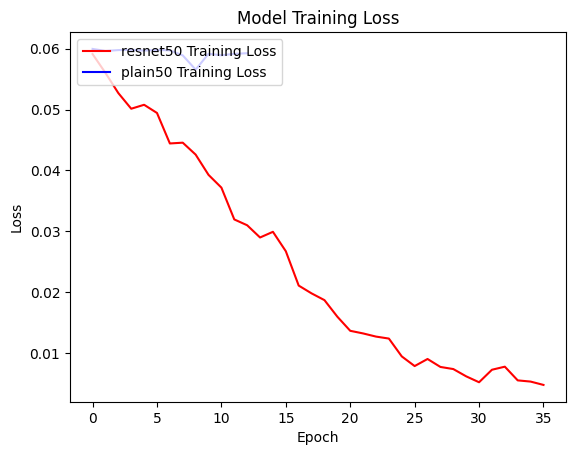

In [10]:
import matplotlib.pyplot as plt

plt.plot(resnet50_train_losses, 'r', label="resnet50 Training Loss")
plt.plot(plain50_train_losses, 'b', label="plain50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

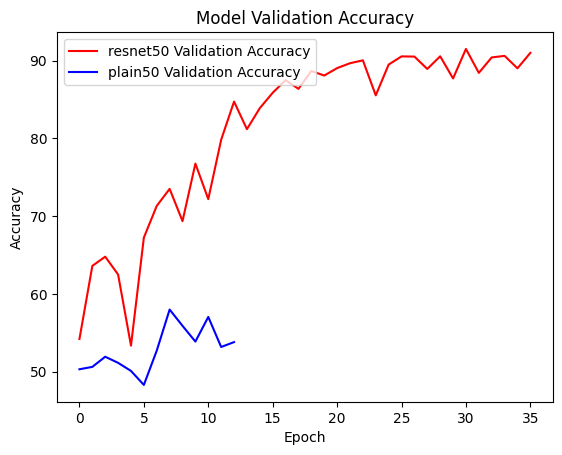

In [11]:
plt.plot(resnet50_val_accuracy, 'r', label="resnet50 Validation Accuracy")
plt.plot(plain50_val_accuracy, 'b', label="plain50 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()